In [1]:
from kaggle.competitions import twosigmanews
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import sklearn
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [3]:
market_train_df = market_train_df.tail(30000)
news_train_df = news_train_df.tail(60000)

In [4]:
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [5]:
def join_market_news(market_train_df, news_train_df):
    news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )
    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Expand news
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))
    del news_train_df, df_assetCodes

    # Aggregate news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    del news_train_df_expanded
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flatten
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])
    del news_train_df_aggregated
    
    return market_train_df

In [6]:
def get_xy(market_train_df, news_train_df, le=None):
    x, le = get_x(market_train_df, news_train_df)
    y = market_train_df['returnsOpenNextMktres10'].clip(-1, 1)
    return x, y, le


def label_encode(series, min_count):
    vc = series.value_counts()
    le = {v:k for k, v in enumerate(vc.index[vc >= min_count])}
    return le


def get_x(market_train_df, news_train_df, le=None):
    # Ensure times are correct
    news_train_df['time'] = (news_train_df['time'] - np.timedelta64(22,'h')).dt.ceil('1D')
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join
    x = join_market_news(market_train_df, news_train_df)
    
    # Encode assetName and assetCode
    if le is None:
        le_assetCode = label_encode(x['assetCode'], min_count=10)
        le_assetName = label_encode(x['assetName'], min_count=5)
    else:
        le_assetCode, le_assetName = le
        
    x['assetCode'] = x['assetCode'].map(le_assetCode).fillna(-1).astype(int)
    x['assetName'] = x['assetName'].map(le_assetName).fillna(-1).astype(int)
    
    try:
        x.drop(columns=['returnsOpenNextMktres10'], inplace=True)
    except:
        pass
    try:
        x.drop(columns=['universe'], inplace=True)
    except:
        pass
    x['dayofweek'], x['month'] = x.time.dt.dayofweek, x.time.dt.month
    x.drop(columns='time', inplace=True)

    # Fix mixed-type columns
    for col in ['marketCommentary_min', 'marketCommentary_max']:
        x[col] = x[col].astype(float)
    
    return x, (le_assetCode, le_assetName)

In [7]:
X, y, le = get_xy(market_train_df, news_train_df)

In [8]:
universe = market_train_df['universe']
time = market_train_df['time']

del market_train_df, news_train_df

In [9]:
n_train = int(X.shape[0] * 0.6)
n_test = int(X.shape[0] * 0.8)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:n_test], y.iloc[n_train:n_test]
X_test, y_test = X.iloc[n_test:], y.iloc[n_test:]

In [10]:
u_valid = (universe.iloc[n_train:n_test] > 0)
t_valid = time.iloc[n_train:n_test]

X_valid = X_valid[u_valid]
y_valid = y_valid[u_valid]
t_valid = t_valid[u_valid]
del u_valid

In [11]:
train_cols = X.columns.tolist()
categorical_cols = ['assetCode', 'assetName', 'dayofweek', 'month']

dtrain = lgb.Dataset(X_train.values, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

Inspired by "A simple mode - using the market and news" and "Two Sigma Financial News Competition Official Getting Started Kernel". 

In [12]:
def f(x):
    print(x)    
    
    params = dict(
    objective = 'mse',
    learning_rate = x[0],
    num_leaves = x[1],
    max_depth = -1,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
    min_data_in_leaf= x[2],
    max_bin= x[3],
    seed = 8 
)
    evals_result = {}
    gbm = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=20, evals_result=evals_result)
    
    return sklearn.metrics.mean_squared_error(gbm.predict(X_valid, num_iteration=gbm.best_iteration), y_valid.astype(float))

params = [
    (0.05, 0.25), #learning_rate
    (100, 2500), #num_leaves
    (150, 250), #min_data_in_leaf
    (150, 350) #max_bin
    ]

from skopt import gp_minimize
res = gp_minimize(
    f, params,
    acq_func="EI",
    n_calls=10)
x = res.x
print(res.x)


[0.20892726565061098, 2063, 247, 279]


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00330048
[50]	valid's l2: 0.00327178
[75]	valid's l2: 0.00322183
[100]	valid's l2: 0.00320176
[125]	valid's l2: 0.00322436
Early stopping, best iteration is:
[108]	valid's l2: 0.00319142
[0.1410964478460639, 155, 201, 298]
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	valid's l2: 0.00330229
[50]	valid's l2: 0.00326941
[75]	valid's l2: 0.00321365
[100]	valid's l2: 0.00319506
[125]	valid's l2: 0.00318483
Early stopping, best iteration is:
[112]	valid's l2: 0.0031635
[0.1487574802187534, 1673, 241, 265]


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00329114
[50]	valid's l2: 0.00324698
[75]	valid's l2: 0.00320404
[100]	valid's l2: 0.00318071
Early stopping, best iteration is:
[85]	valid's l2: 0.00316369
[0.18635835259545053, 1149, 160, 261]


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00324815
[50]	valid's l2: 0.00322587
[75]	valid's l2: 0.00321118
[100]	valid's l2: 0.00321284
[125]	valid's l2: 0.00325011
Early stopping, best iteration is:
[108]	valid's l2: 0.00319271
[0.18735427364797874, 377, 193, 186]
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	valid's l2: 0.00322792
[50]	valid's l2: 0.00319554
[75]	valid's l2: 0.00319587
Early stopping, best iteration is:
[62]	valid's l2: 0.00317494
[0.24412833205906992, 319, 238, 154]
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	valid's l2: 0.00327581
[50]	valid's l2: 0.00326239
[75]	valid's l2: 0.00321571
[100]	valid's l2: 0.00322976
Early stopping, best iteration is:
[83]	valid's l2: 0.00320756
[0.15148510715453917, 687, 223, 287]
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	valid's l2: 0.00330629
[50]	valid's l2: 0.00325662
[75]	valid's l2: 0.00320532
[100]	valid's l2: 0.00317194
[125]	valid's l2: 0.00316948
Early stopping, best iteration is:
[108]	valid's l2: 0.00315138
[0.18105267879445502, 1659, 238, 184]


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00326949
[50]	valid's l2: 0.00322264
[75]	valid's l2: 0.00317629
[100]	valid's l2: 0.00315818
[125]	valid's l2: 0.0031507
Early stopping, best iteration is:
[116]	valid's l2: 0.00313318
[0.207994501665347, 431, 234, 326]
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	valid's l2: 0.00326028
[50]	valid's l2: 0.00321612
Early stopping, best iteration is:
[44]	valid's l2: 0.00320222
[0.1485636274886989, 990, 203, 249]


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00326293
[50]	valid's l2: 0.00322631
[75]	valid's l2: 0.00318221
Early stopping, best iteration is:
[76]	valid's l2: 0.00317726
[0.18105267879445502, 1659, 238, 184]


In [13]:
#x = [0.13989172259050747, 437, 205, 215]

lgb_params = dict(
    objective = 'mse',
    learning_rate = x[0],
    num_leaves = x[1],
    max_depth = -1,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
    min_data_in_leaf= x[2],
    max_bin= x[3],
    seed = 8
)

evals_result = {}
model = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=20, evals_result=evals_result)


df_result = pd.DataFrame(evals_result['valid'])

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds.
[25]	valid's l2: 0.00326949
[50]	valid's l2: 0.00322264
[75]	valid's l2: 0.00317629
[100]	valid's l2: 0.00315818
[125]	valid's l2: 0.0031507
Early stopping, best iteration is:
[116]	valid's l2: 0.00313318


In [14]:
def make_predictions(predictions_template_df, market_obs_df, news_obs_df, le):
    x, _ = get_x(market_obs_df, news_obs_df, le)
    predictions_template_df.confidenceValue = np.clip(model.predict(x), -1, 1)

In [15]:
def error_histogram(y_pred, y_true):
    plt.style.use("seaborn-paper")
    error = np.subtract(y_pred, y_true)
    print(np.std(error))
    plt.hist(error, bins = np.linspace(-0.25, 0.25, 100), alpha=0.3, color='r')
    plt.xlabel("Error in 10-day return")
    plt.ylabel("Frequency")
    plt.title("Error Histogram")
    plt.show()

In [16]:
def training_accuracy(X, y):
    y_pred = []
    y_true = []    
    y_true = y
    y_pred = model.predict(X)
    
    MSE = sklearn.metrics.mean_squared_error(y_true, y_pred)
    accuracy = accuracy_score(np.array(y_true)>0,np.array(y_pred)>0)
    
    plt.hist(y_true, bins=np.linspace(-0.5,0.5,150), alpha=0.3)
    plt.hist(y_pred, bins=np.linspace(-0.5,0.5,150), alpha=0.3, color='darkorange')
    plt.legend(['Ground truth', 'Predicted'])
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("predicted confidence")
    plt.show()

    error_histogram(y_pred, y_true)
    return MSE, accuracy

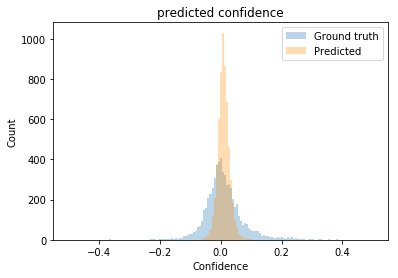

0.07200911809589496


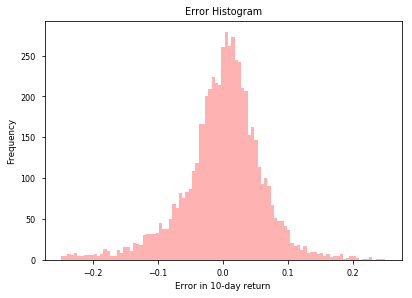

Test MSE = 0.005197873491962922, Test Accuracy = 0.542


In [17]:
test_mse, test_accuracy = training_accuracy(X_test, y_test)
print ("Test MSE = " + str(test_mse) + ", Test Accuracy = " + str(test_accuracy))

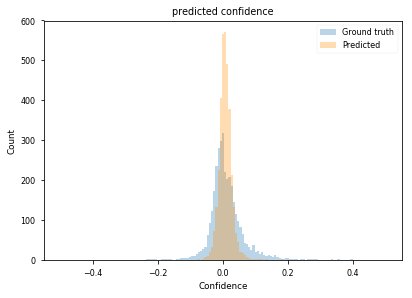

0.05582049564956733


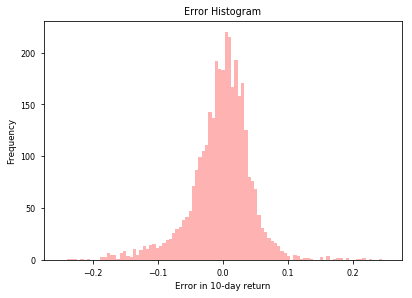

Valid MSE = 0.0031331754500269634, Valid Accuracy = 0.580034924330617


In [18]:
valid_mse, valid_acc = training_accuracy(X_valid, y_valid)
print ("Valid MSE = " + str(valid_mse) + ", Valid Accuracy = " + str(valid_acc))

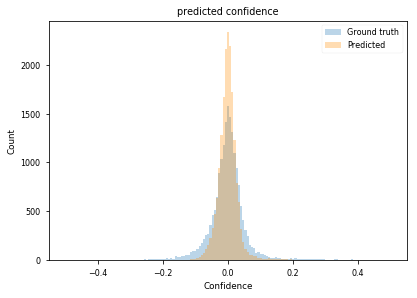

0.039547577546980024


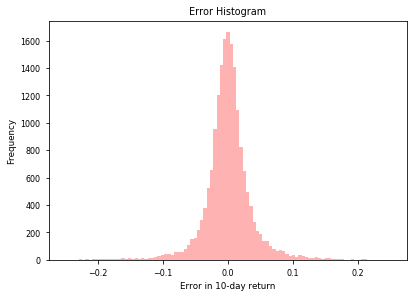

Train MSE = 0.0015640121550406839, Train Accuracy = 0.774


In [19]:
train_mse, train_acc = training_accuracy(X_train, y_train)
print ("Train MSE = " + str(train_mse) + ", Train Accuracy = " + str(train_acc))

In [20]:
dtrain_full = lgb.Dataset(X, y, feature_name=train_cols, categorical_feature=categorical_cols)

model = lgb.train(lgb_params, dtrain, num_boost_round=df_result['l2'].idxmin()+1)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [21]:
days = env.get_prediction_days()

for (market_obs_df, news_obs_df, predictions_template_df) in days:
    make_predictions(predictions_template_df, market_obs_df, news_obs_df, le)
    env.predict(predictions_template_df)
print('Done!')

Done!


In [22]:
env.write_submission_file()

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
